# Experimentation guide in Python

1. [Designing our experiment](#1.-Designing-our-experiment)
2. [The Data](#2.-Get-the-Data)
3. [Frequentist Approach](#3.-Frequentist-Approach)
4. [Bayesian Approach](#4.-Bayesian-Approach)
5. [Multi Arm Bandits](#5.-Multi-Arm-Bandits)
6. [Sample size for means](#6.-Calculating-sample-size-for-means)
7. [Assesing randomness](#7.-Assesing-randomness)

![](https://miro.medium.com/max/1400/1*2hGMrCjLtVKtOKD_QnyuWA.png)

In [23]:
# source ~/anaconda3/etc/profile.d/conda.sh
# conda activate pymc_env

In this notebook we'll go over the process of analysing an A/B test, from formulating a hypothesis, testing it, and finally interpreting results. We will examine the two main methodologies, namely the **Frequentist** approach and the **Bayesian** approach.

To make it a bit more realistic, here's a potential **scenario** for our study:

> Let's imagine you work on the product team at an **online survey business**. The business is interested in increasing the  Response of users they send out surveys to. To do this, they want to test out a different `subject line` with the aim that it will lead to a higher response rate. The product manager (PM) told you that the **current response rate** is about **13%** on average throughout the year, and that the team would be happy with an **increase of 2%**, meaning that the new subject line will be considered a success if it raises the reponse rate to 15%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an **A/B test** on a subset of your user base.

***
## 1. Designing our experiment

<div style="text-align: right"
     
[top](#Experimentation-guide-in-Python)

### Formulating a hypothesis

First things first, we want to make sure we formulate a hypothesis at the start of our project. This will make sure our interpretation of the results is correct as well as rigorous.

Given we don't know if the new design will perform better or worse (or the same?) as our current design, we'll choose a <a href="https://en.wikipedia.org/wiki/One-_and_two-tailed_tests">**two-tailed test**</a>:

$$H_0: p = p_0$$
$$H_a: p \ne p_0$$

where $p$ and $p_0$ stand for the response rate of the new and old design, respectively. We'll also set a **confidence level of 95%**:

$$\alpha = 0.05$$

The $\alpha$ value is a threshold we set, by which we say "if the probability of observing a result as extreme or more ($p$-value) is lower than $\alpha$, then we reject the null hypothesis". Since our $\alpha=0.05$ (indicating 5% probability), our confidence (1 - $\alpha$) is 95%.

Don't worry if you are not familiar with the above, all this really means is that whatever response rate we observe for our new design in our test, we want to be 95% confident it is statistically different from the response rate of our old design, before we decide to reject the Null hypothesis $H_0$. 

### Choosing the variables

For our experiment we'll need **two groups**:
* A `control` group - They'll be shown the old subject line
* A `treatment` (or experimental) group - They'll be shown the new subject line

This will be our *Independent Variable*. The reason we have two groups even though we know the baseline response rate is that we want to control for other factors that could have an effect on our results, such as seasonality: by having a `control` group we can directly compare their results to the `treatment` group, because the only systematic difference between the groups is the subject line, and we can therefore attribute any differences in results to that.

For our *Dependent Variable* (i.e. what we are trying to measure), we are interested in capturing the `reponse rate`. The way we campture this is with a binary variable:
* `0` - The user did not respond to the survey
* `1` - The user responded to the survey

This way, we can easily calculate the mean for each group to get the response rate of each subject line.

### Choosing a sample size

It is important to note that since we won't test the whole user base (our <a href="https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/3-populations-and-samples">population</a>), the response rates that we'll get will inevitably be only *`estimates`* of the true rates.

The number of people we decide to capture in each group will have an effect on the precision of our estimated response rates: **the larger the sample size** then <br>
(1) the more precise our estimates (i.e. the narrower our confidence intervals) and <br>
(2) the higher our chance to detect a difference in the two groups, if present.

We do not want to run the test on all of our users, since we want to be sure that the treatment variant is performing better

*So how many people should we have in each group?*

The sample size we need is estimated through something called <a href="https://stats.oarc.ucla.edu/other/mult-pkg/seminars/intro-power/">*Power analysis*</a>, and it depends on a few factors:
* **Power of the test** ($1 - \beta$) - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention (here's more info on <a href="https://en.wikipedia.org/wiki/Power_of_a_test">statistical power</a>, if you are curious)
* **Alpha value** ($\alpha$) - The critical value we set earlier to 0.05
* **Effect size** - How big of a difference we expect there to be between the conversion rates

Since our team would be happy with a difference of 2%, we can use 13% and 15% to calculate the effect size we expect. 

Luckily, **Python takes care of all these calculations for us**:

In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

In [4]:
CURRENT_RR = 0.13 # our historical RR
DESIRABLE_RR = 0.15 # the RR we would like to be able to detect

effect = sms.proportion_effectsize(CURRENT_RR, DESIRABLE_RR)    # Calculating effect size based on our expected rates
# or Cohens effect : 2 * (np.arcsin(np.sqrt(CURRENT_RR)) - np.arcsin(np.sqrt(DESIRABLE_RR)))

RATIO =  1 # the ratio of samples of # TREATMENT over # CONTROL group (usually its 1) (TREATMENT/CONTROL)

required_n = sms.NormalIndPower().solve_power(
    effect_size = effect, 
    power=0.8, # default value
    alpha=0.05, # default value
    ratio=RATIO
    ) # Calculating sample size needed
# print(required_n)
required_n = int(np.ceil(required_n)) # Rounding up to next whole number                          

print(f"Group Control requires {required_n:,} samples")
print(f"Group Treatment requires {int(required_n * RATIO):,} samples")
print(f"Requiring a total of {int(required_n + required_n * RATIO):,} samples")

Group Control requires 4,720 samples
Group Treatment requires 4,720 samples
Requiring a total of 9,440 samples


In [5]:
# Helper function
def proportion_diff(COTROL_RR, N, RATIO=1):
    Effect = sms.NormalIndPower().solve_power(
        nobs1=N, 
        power=0.8, # default value
        alpha=0.05, # default value
        ratio=RATIO
    )
    TREATMENT_RR = ((np.sin(np.arcsin(np.sqrt(COTROL_RR)) + Effect/2))**2 )
    return  TREATMENT_RR - COTROL_RR

In [6]:
proportion_diff(0.13, 9_440)

0.014018106893377291

We'd need **at least 4720 observations for each group**. 

Having set the `power` parameter to 0.8 in practice means that if there exists an actual difference in response rate between our subject lines, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

***
## 2. Get the Data

<div style="text-align: right"
     
[top](#Experimentation-guide-in-Python)

### Lets create some fake data

In [11]:
np.random.seed(42) # this is so the random numbers can be replicated

ACTUAL_Resp_CONTROL = 0.13 # this is what the population RR would be for our current subject line
ACTUAL_Resp_TREATMENT = 0.137 # this is what the population RR would be for the alternative subject line
ACTUAL_DIFF = np.round(ACTUAL_Resp_TREATMENT - ACTUAL_Resp_CONTROL, 7)

CONTROL = np.random.binomial(n=1, p=ACTUAL_Resp_CONTROL, size=required_n)
TREATMENT = np.random.binomial(n=1, p=ACTUAL_Resp_TREATMENT, size=int(required_n * RATIO))

# CONTROL = (np.random.random(required_n) < ACTUAL_Resp_CONTROL)*1
# TREATMENT = (np.random.random(required_n) < ACTUAL_Resp_TREATMENT)*1

SAMPLE_DIFF = np.mean(TREATMENT) - np.mean(CONTROL)

In [12]:
# lets use different samples
np.random.seed(42)
N = 410
N = 4_720

res = np.round((np.mean(TREATMENT[:N]) - np.mean(CONTROL[:N]))*100, 2)

print(f'Treatment Response Rate - Control Respense Rate = \033[1m{res}\033[0m%')

Treatment Response Rate - Control Respense Rate = 0.42%


### No early peeking

When performing a Frequentist AB test we should not look at our results before the experiment is over, i.e. before we used all of the sample size.<br> Doing so may leed to the wrong conclutions. 

In [9]:
# Here we take the difference between treatment and control after every 100 surveys
sample_diffs = \
[np.mean(TREATMENT[:i*100]) - np.mean(CONTROL[:i*100]) for i in range(1,41)] +\
[np.mean(TREATMENT) - np.mean(CONTROL)]

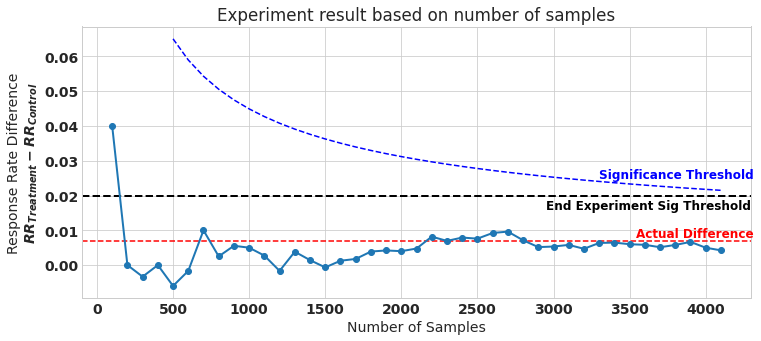

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
x = np.linspace(100, 4100, 41)
ax.axhline(ACTUAL_DIFF, color = 'r', linestyle = '--')
ax.axhline(0.02, color = 'black', linestyle = '--', lw=2)

ax.plot(x, sample_diffs, '-o', lw=2)
ax.plot(x[4:], [proportion_diff(CURRENT_RR, el) for el in x[4:]], '--', color = 'b',lw=1.5)

ax.annotate('Actual Difference', xy =(3540, 0.008), color='red', size=12)
ax.annotate('Significance Threshold', xy =(3300, 0.025), color='blue', size=12)
ax.annotate('End Experiment Sig Threshold', xy =(2950, 0.016), color='black', size=12)

plt.xlabel("Number of Samples")
plt.ylabel("Response Rate Difference\n$RR_{Treatment} - RR_{Control}$")
plt.title('Experiment result based on number of samples');

But this is just one simulation. Lets run one hundred of them

In [13]:
SIMULATIONS = 100

np.random.seed(42)
CONTROLs = np.random.binomial(n=1, p=ACTUAL_Resp_CONTROL, size=(required_n, SIMULATIONS))
TREATMENTs = np.random.binomial(n=1, p=ACTUAL_Resp_TREATMENT, size=(int(required_n * RATIO), SIMULATIONS))

In [14]:
sample_diffs = \
[np.mean(TREATMENTs[:i*100], axis=0) - np.mean(CONTROLs[:i*100], axis=0) for i in range(1,41)] +\
[np.mean(TREATMENTs, axis=0) - np.mean(CONTROLs, axis=0)]

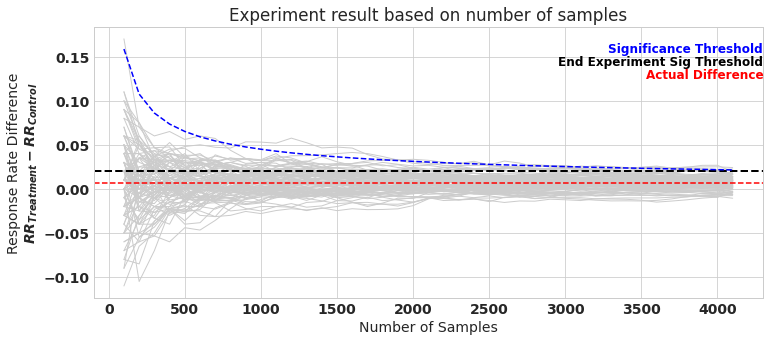

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
x = np.linspace(100, 4100, 41)

ax.plot(x, sample_diffs, '-', lw=1, c='0.80')
ax.axhline(ACTUAL_DIFF, color = 'r', linestyle = '--')
ax.axhline(0.02, color = 'black', linestyle = '--', lw=2)

ax.plot(x[0:], [proportion_diff(CURRENT_RR, el) for el in x[0:]], '--', color = 'b',lw=1.5)

ax.annotate('Actual Difference', xy =(3530, 0.125), color='red', size=12)
ax.annotate('Significance Threshold', xy =(3280, 0.155), color='blue', size=12)
ax.annotate('End Experiment Sig Threshold', xy =(2950, 0.14), color='black', size=12)

plt.xlabel("Number of Samples")
plt.ylabel("Response Rate Difference\n$RR_{Treatment} - RR_{Control}$")
plt.title('Experiment result based on number of samples');

In [14]:
# # Paidia kai keria

# import numpy as np

# np.mean([(x[2] > min(x[0], x[1])) & (x[2] < max(x[0], x[1])) for x in np.random.random((1_000_000, 3))])

# result = []
# for x in np.random.random((100_000, 3)):
#     if (x[2] > min(x[0], x[1])) & (x[2] < max(x[0], x[1])):
#         result.append(1)
#     else:
#         result.append(0)

In [15]:
# np.sum(np.array([(sim[1] > (DESIRABLE_RR - CURRENT_RR)) & \
#                  (sim[-1] < (DESIRABLE_RR - CURRENT_RR)) for sim in np.array(sample_diffs).T]))

30

In [16]:
# np.sum(np.array([(sim[1] < (DESIRABLE_RR - CURRENT_RR)) & \
#                  (sim[-1] > (DESIRABLE_RR - CURRENT_RR)) for sim in np.array(sample_diffs).T]))

2

In [17]:
df = pd.concat([pd.DataFrame({'Submitted':CONTROL, 'Group':['CONTROL'] * len(CONTROL)}), 
                pd.DataFrame({'Submitted':TREATMENT, 'Group':['TREATMENT']* len(TREATMENT)})])

In [18]:
resp_rates = df.groupby('Group')['Submitted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

resp_rates = resp_rates.agg([np.mean, std_p, se_p])
resp_rates.columns = ['Response_rate', 'std_deviation', 'std_error']


resp_rates.style.format('{:.4f}')

,Response_rate,std_deviation,std_error
Group,,,
CONTROL,0.1273,0.3333,0.0049
TREATMENT,0.1316,0.3380,0.0049


Judging by the stats above, it does look like **our two subject lines performed very similarly**, with our new Subject line performing slightly better, approx. **13.16% vs. 12.73% response rate**.

Plotting the data will make these results easier to grasp:

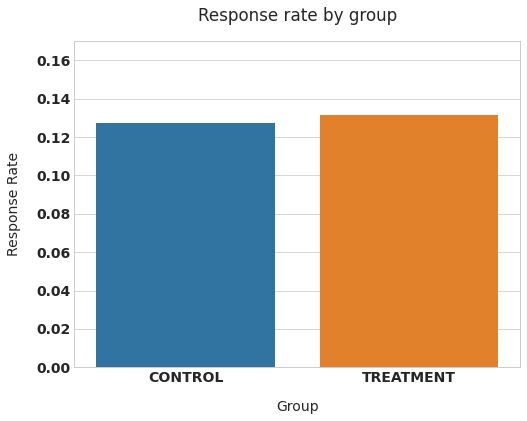

In [19]:
plt.figure(figsize=(8,6))

sns.barplot(x=df['Group'], y=df['Submitted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Response rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Response Rate', labelpad=15);

So... the `treatment` group's value is higher, but **is this difference *statistically significant***?

***
## 3. Frequentist Approach

<div style="text-align: right"
     
[top](#Experimentation-guide-in-Python)

The last step of our analysis is testing our hypothesis. Since we have a large sample (above 50 cases), we can use the <a href="https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_approximation_interval">normal approximation</a> for calculating our $p$-value (i.e. the $z\ test$). 

Again, Python makes all the calculations very easy. We can use the `statsmodels.stats.proportion` module to get the $p$-value and confidence intervals:

In [20]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [21]:
control_results = df[df['Group'] == 'CONTROL']['Submitted']
treatment_results = df[df['Group'] == 'TREATMENT']['Submitted']

In [22]:
control_results

0       0
1       1
2       0
3       0
4       0
       ..
4715    0
4716    0
4717    1
4718    0
4719    1
Name: Submitted, Length: 4720, dtype: int32

In [23]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.61
p-value: 0.540
ci for control group: [0.118, 0.137]
ci for treatment group: [0.122, 0.141]


In [24]:
from scipy.stats import ttest_ind

print(f'p-value: {ttest_ind(control_results, treatment_results, equal_var=True).pvalue:.1%}')

p-value: 54.0%


Since the `P-value` is greater than our significance level `α`, namely $0.540 > 0.05$ we cannot reject the null hypothesys, that is, the two variants have similar results.

In [25]:
def ci_proportions_plot(Control_results, Treatment_results, 
                        xaxis_title='', title_='', theme='fivethirtyeight', 
                        size_=(10, 6), colors=['#07337a', '#7a0707'], 
                       bar_width=32):
    
    # These libraries need to be loaded
    # from statsmodels.stats.proportion import proportions_ztest, proportion_confint
    # import numpy as np
    # import pandas as pd
    
    successes = [Control_results.sum(), Treatment_results.sum()]
    rates = [np.mean(Control_results), np.mean(Treatment_results)]
    nobs = [len(Control_results), len(Treatment_results)]
    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    
    res = pd.DataFrame({'Variant':['CONTROL', 'TREATMENT'], 
              'Metric':rates, 
              'Interval_95':[np.mean(Control_results)-proportion_confint(successes, nobs=nobs, alpha=0.05)[0][0], 
                             np.mean(Treatment_results)-proportion_confint(successes, nobs=nobs, alpha=0.05)[0][1]],
              'Interval_90':[np.mean(Control_results)-proportion_confint(successes, nobs=nobs, alpha=0.1)[0][0], 
                             np.mean(Treatment_results)-proportion_confint(successes, nobs=nobs, alpha=0.1)[0][1]],
              'Color':colors         })
    
#     print(res)
    
    plt.style.use(theme)
    
    fig, ax = plt.subplots(nrows=1, sharex=True)
    fig.set_size_inches(size_[0], size_[1])
    
    
    metric_list = []
    for i, row in enumerate(res.itertuples()):

        metric_list.append(row[row._fields.index('Metric')])
        
        markers, caps, bars = ax.errorbar(row[row._fields.index('Metric')],
                    i,
                    xerr=[[row.Interval_95], [row.Interval_95]],
                    fmt='d', elinewidth=bar_width, ecolor=row.Color,
                    markersize=int(bar_width/3), markeredgecolor='white', markerfacecolor='white')
        [bar.set_alpha(0.5) for bar in bars]
        
        ax.errorbar(row[row._fields.index('Metric')],
                    i,
                    xerr=[[row.Interval_90], [row.Interval_90]],
                    fmt='d', elinewidth=bar_width, ecolor=row.Color,
                    markersize=int(bar_width/3), markeredgecolor='white', markerfacecolor='white')


    ax.errorbar(min(metric_list), -1, xerr=[[0], [0]], fmt='o', markersize=0.01)
    ax.errorbar(max(metric_list), res.shape[0], xerr=[[0], [0]], fmt='o', markersize=0.01)
    
    mx = np.max(res['Metric']+res['Interval_90'])
    
    ax.annotate('Control', xy=(mx,1.4), color=colors[0])
    ax.annotate('Treatment', xy=(mx,1.5), color=colors[1])
    
    ax.annotate(' CI 90%', xy=(mx+0.001,-0.52), color='black')
    ax.annotate(' CI 95%', xy=(mx+0.001,-0.62), color='grey')
    
    ax.annotate('▇▇', xy=(mx,-0.5), color='black')
    ax.annotate('▇▇', xy=(mx,-0.6), color='grey')

    ax.set_title(title_)
    ax.set_yscale('linear')
    ax.set_xlabel(xaxis_title)
    ax.get_yaxis().set_visible(False)
#     ax.legend().set_visible(False)
    plt.ylim(-0.65, 1.65)
    plt.show()
    
#     return res
    
    
    

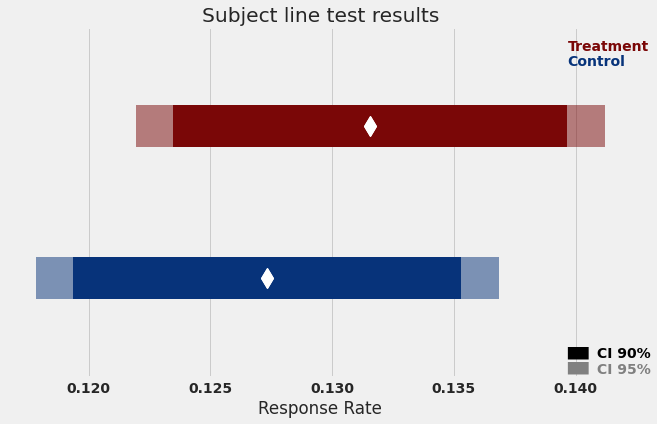

In [26]:
ci_proportions_plot(control_results, treatment_results, bar_width=42, 
                    title_='Subject line test results', xaxis_title='Response Rate')

***
## 4. Bayesian Approach

<div style="text-align: right"
     
[top](#Experimentation-guide-in-Python)

In the <b>Bayesian</b> setting we will use a prior distribution (a probability distribution) to indicate our beliefs about 
the unknown Response Rate (the unknown variable) prior to drawing samples from the underlying population. <br>
We then use this data to update our beliefs about the Reponse Rate using Bayes’ Rule

This A/B testing procedure has two main advantages over the Frequentist approach. 
- The first is that you can stop the test early if there is a clear winner or run it for longer if you need more samples. 
- The second is that as a Bayesian test, your outputs are easily interpreted quantities - for example, the probability that version A is better than version B, or your expected loss from choosing the wrong one.

<b>Bayes Rule</b>:
![Bayes Furmula](https://miro.medium.com/max/608/1*cqj0PxjS6og4FawGHMyGVg.png)

which, in words can be written as:
![Bayes is words](https://miro.medium.com/max/622/1*XglKD6Eb6NxolbAS1Ajxng.png)

It can be simplified to:
![Bayes simplified](https://miro.medium.com/max/688/1*4BEIXoQu7wzmTolgoLXfhg.png)

Fisrt thing is first, we need to set our $Prior$ beliefs. We have two choises for the prior (i.e. our initial beliefs). 
- Weak priors (or non informative)
- Informative priors

### Weak Priors

In [7]:
from scipy.stats import beta, bernoulli

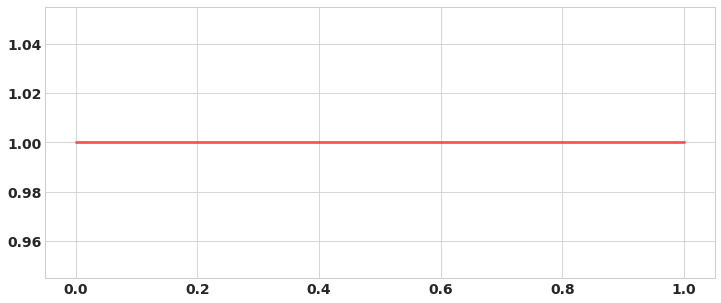

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
a, b = 1, 1
x = np.linspace(0, 1, 100)
ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=3, alpha=0.6, label='beta pdf');

In the weak prior case every Response Rate is equally likely to come up.

### Informative Priors

But we have hostorical data on the Response Rate. We can use this to define our $Prior$ knowledge about the Response Rate

#### Historical Data

Lets assume we have the following historical data on Response rate

In [16]:
np.random.seed(42)

HISTORIC_RR = np.random.binomial(n=1, p=ACTUAL_Resp_CONTROL, size=1_330_000)

print(f"Average RR of 'Historical' Response Rates are {np.round(np.mean(HISTORIC_RR), 3)}")

Average RR of 'Historical' Response Rates are 0.13


Lets take 1000 partitions of our historic data and plot a histogram of the response rate for each partition. (The 1000 partitions are arbitary)

In [17]:
partitions = np.array_split(HISTORIC_RR, 1000)

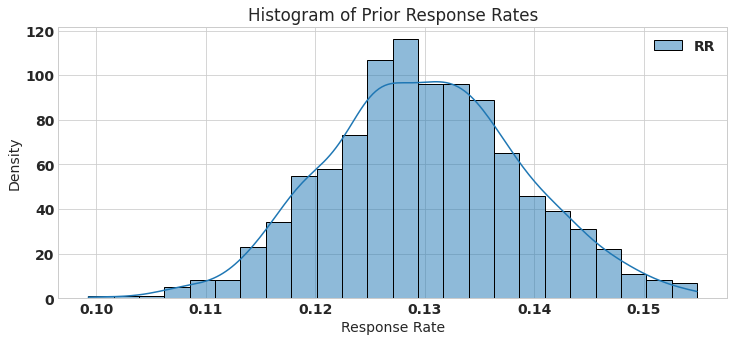

In [18]:
rates = np.mean(partitions, axis=1)

_, ax = plt.subplots(figsize=(12, 5))
sns.histplot(rates, kde=True, label='RR')
ax.legend()
ax.set_xlabel('Response Rate')
ax.set_ylabel('Density')
ax.set_title('Histogram of Prior Response Rates');

We could use the above as our prior, the $Beta$ distribution this would be:

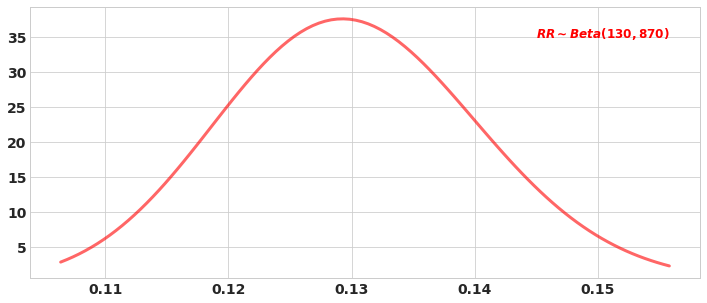

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
a, b = 130, 1000-130
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=3, alpha=0.6, label='beta pdf')

ax.annotate('$RR \sim Beta(130, 870)$', xy =(0.145, 35), color='red', size=12);

Lets make it a bit weaker than what we see from the historical Response Rates

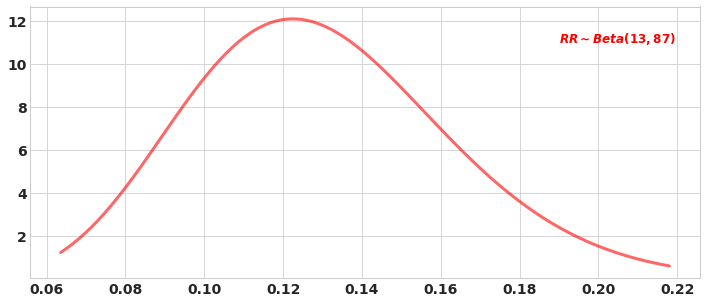

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
a, b = 13, 100-13
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=3, alpha=0.6, label='beta pdf')

ax.annotate('$RR \sim Beta(13, 87)$', xy =(0.19, 11), color='red', size=12);

A nice resourse for distributions is at the [distribution zoo](https://ben18785.shinyapps.io/distribution-zoo/)

### Bayesian code set up

How to install [pymc](https://docs.pymc.io/en/v3/) (probabilistic programming language in python)

- Choose a "Region Of Practical Equivelance ROPE" - if A and B differ by less than this threshold, you don't care which one you choose.
- Choose a prior on the distribution of conversion rates of A and B.
- Compute a posterior, and use it to estimate whether the expected losses you'd make by choosing A (or B) are below the threshold of caring. If so, stop the test.

In [36]:
# import sys
# print(sys.executable)

# pip install pymc --pre
# !C:\Users\dpsar\Anaconda3\python.exe -m pip install scipy==1.7.3 --user
# !C:\Users\dpsar\Anaconda3\python.exe -m pip install pymc3 --user

In [37]:
import pymc3 as pm
import arviz as az

Using NumPy C-API based implementation for BLAS functions.


In [38]:
ACTUAL_DIFF

0.007

In [39]:
resp_rates.style.format('{:.4f}')

,Response_rate,std_deviation,std_error
Group,,,
CONTROL,0.1273,0.3333,0.0049
TREATMENT,0.1316,0.3380,0.0049


In [34]:
# Non informative priors
with pm.Model():
    CONTROL = pm.Beta('CONTROL', 1, 1)
    TREATMENT = pm.Beta('TREATMENT', 1, 1)
    
    lift = pm.Deterministic('lift', TREATMENT - CONTROL)
    
    
    B_obs = pm.Bernoulli('B_obs', TREATMENT, observed=treatment_results.values)
    A_obs = pm.Bernoulli('A_obs', CONTROL, observed=control_results.values)
    
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [TREATMENT, CONTROL]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable C:\Program
Could not locate executable efl


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


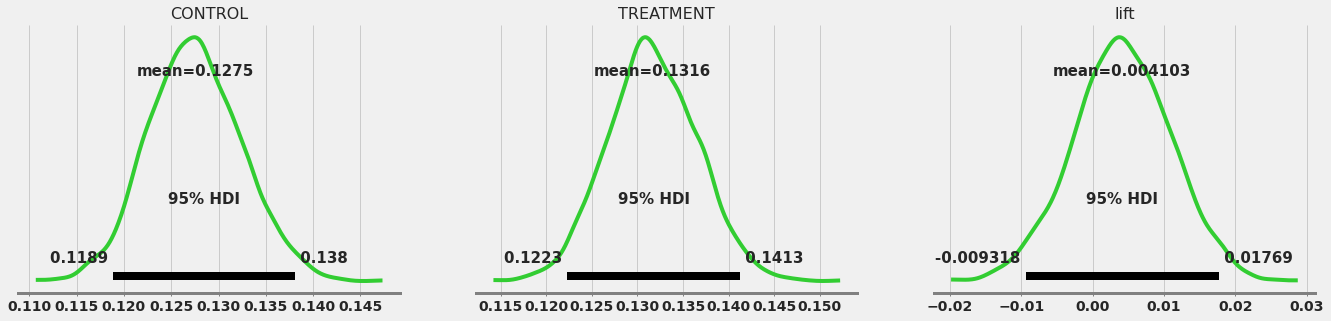

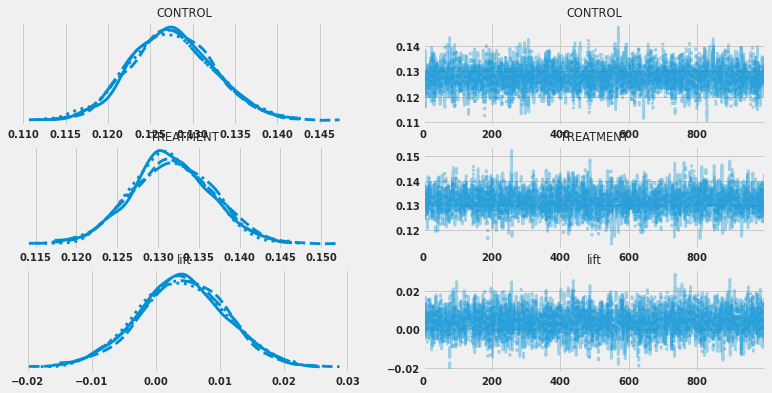

In [35]:
with pm.Model():
    az.plot_posterior(trace, hdi_prob = 0.95, color = 'limegreen' , round_to=4)
    az.plot_trace(trace)

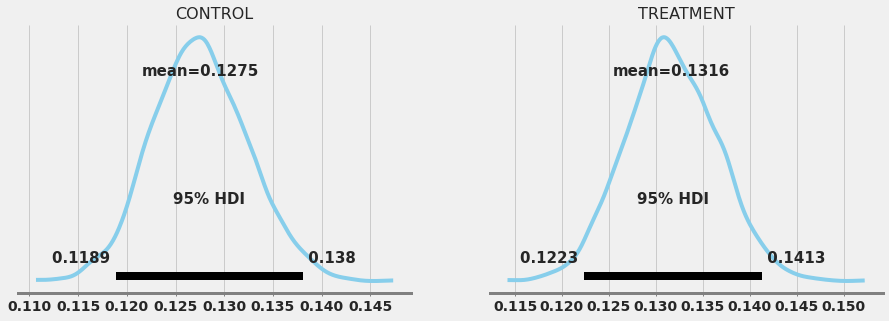

In [36]:
pm.plot_posterior(trace, ['CONTROL','TREATMENT'],color='#87ceeb', round_to=4, hdi_prob = 0.95);

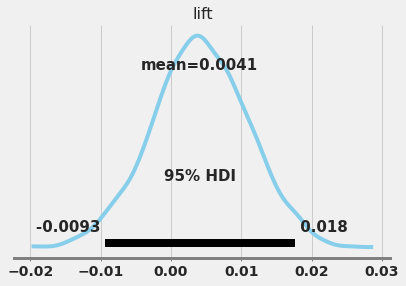

In [37]:
pm.plot_posterior(trace, ['lift'],color='#87ceeb', hdi_prob = 0.95);

In [38]:
# Weakly informative priors
with pm.Model():
    CONTROL = pm.Beta('CONTROL', 1.5, 4)
    TREATMENT = pm.Beta('TREATMENT', 1.5, 4)
    
    lift = pm.Deterministic('lift', TREATMENT - CONTROL)
    
    A_obs = pm.Bernoulli('A_obs', CONTROL, observed=control_results.sample(frac=0.5, random_state=1).values)
    B_obs = pm.Bernoulli('B_obs', TREATMENT, observed=treatment_results.sample(frac=0.5, random_state=1).values)
    
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [TREATMENT, CONTROL]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


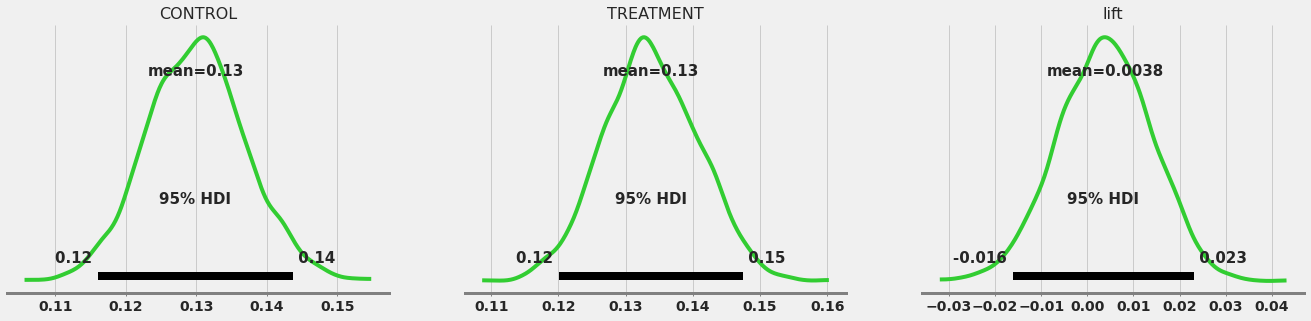

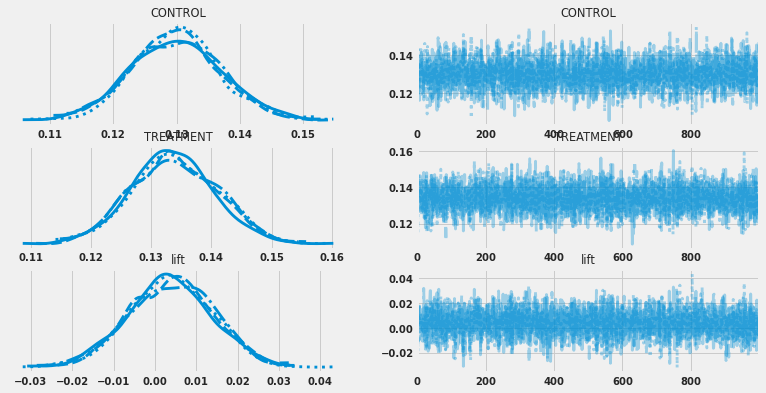

In [39]:
with pm.Model():
    az.plot_posterior(trace, hdi_prob = 0.95, color = 'limegreen')
    az.plot_trace(trace)

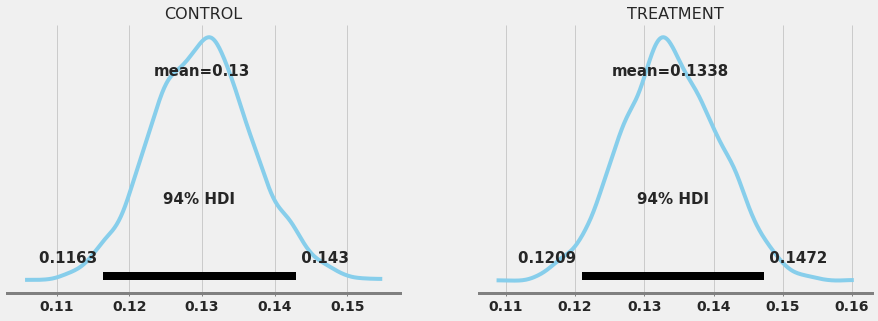

In [40]:
pm.plot_posterior(trace, ['CONTROL','TREATMENT'],color='#87ceeb', round_to=4);

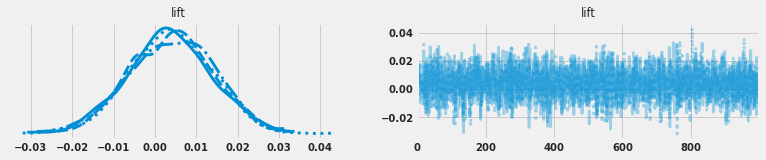

In [41]:
pm.plot_trace(trace,['lift']);

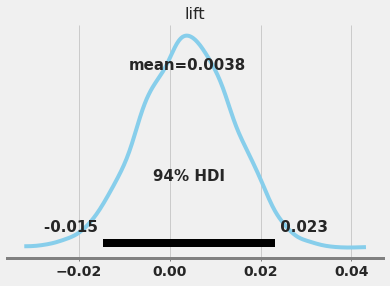

In [42]:
pm.plot_posterior(trace, ['lift'],color='#87ceeb');

In [43]:
with pm.Model():
    display(az.summary(trace, kind='stats', round_to=4))

,mean,sd,hdi_3%,hdi_97%
CONTROL,0.1300,0.0071,0.1163,0.1430
TREATMENT,0.1338,0.0071,0.1209,0.1472
lift,0.0038,0.0102,-0.0146,0.0231


##### Expected Loss & Expected Relative Loss

We see the lift is 0.38% that is, the Treatment has a 0.38% higher Response Rate vs the Control<br>
But the question is, `is this difference big enough?`<br>
We need to check three more values:
- The Probability to be the Best
- The Expected Loss (or Expected Relative Loss)
- Our threshold

The Expected Loss of choosing the Treamtent is:<br>
$E_{Loss}(TREATMENT) = E[max(X_{Control} − X_{Treatment}, 0)]$

The Expected Relative Loss of choosing the Treamtent is:<br>
$ER_{Loss}(TREATMENT) = E[max((X_{Control} − X_{Treatment})/X_{Treatment}, 0)]$

$𝜖 = Relative\ Expected\ Loss$ is the risk of choosing one variant of an experiment over another

In [49]:
ε = 0.005 # 0.5%

In [44]:
def ExpLoss(C, T, Relative=False):
    if not(Relative):
        return np.maximum(C - T, 0).mean()
    else:
        return np.maximum((C - T)/T, 0).mean()

In [45]:
ExpLoss(trace.posterior['CONTROL'].to_numpy(), trace.posterior['TREATMENT'].to_numpy(), Relative=False)

0.0024664890256718454

In [56]:
ExpLoss(C=trace.posterior['CONTROL'].to_numpy(), T=trace.posterior['TREATMENT'].to_numpy(), Relative=True)

0.01953520802974202

In [57]:
print(f"Probability to be the best is: {np.mean(trace.posterior['lift'].to_numpy() >0)*100} %")

Probability to be the best is: 65.25 %


In [58]:
# Should we keep it
ExpLoss(trace.posterior['CONTROL'].to_numpy(), trace.posterior['TREATMENT'].to_numpy(), Relative=True) < ε

False

### Probability to be the best

In [40]:
def beta_plots(a_s, b_s, 
               colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']):
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    max_ = 0
    for params in zip(a_s, b_s, colors[:len(a_s)]):
        a, b, c = params
        x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
        ax.plot(x, beta.pdf(x, a, b),
               color=c, lw=3, alpha=0.6, label='beta pdf')
        max_ = max([np.max(beta.pdf(np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100), a, b)), max_])
    
        
    for i, params in enumerate(zip(a_s, b_s, colors[:len(a_s)])):
        a, b, c = params
        ax.annotate(f'$RR \sim Beta({a}, {b})$', xy =(beta.ppf(0.98, a_s[0], b_s[0]), max_ - i), 
                    color=c, size=12)

In [41]:
from scipy import stats
xa = stats.beta(2, 10).rvs(size=int(1e6))
xb = stats.beta(3, 12).rvs(size=int(1e6))
(xb > xa).mean()

0.604461

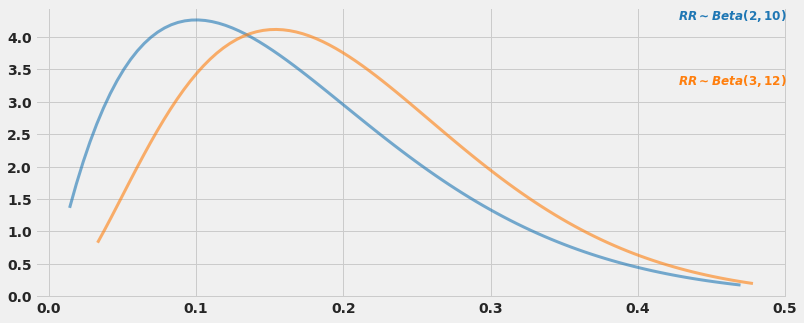

In [42]:
beta_plots([2, 3], [10, 12])

In [43]:
xa = stats.beta(2, 10).rvs(size=int(1e6))
xb = stats.beta(3, 12).rvs(size=int(1e6))
xc = stats.beta(5, 60).rvs(size=int(1e6))
xd = stats.beta(7, 90).rvs(size=int(1e6))

maxall = np.maximum.reduce([xa, xc, xd])

(xb > maxall).mean()

0.576023

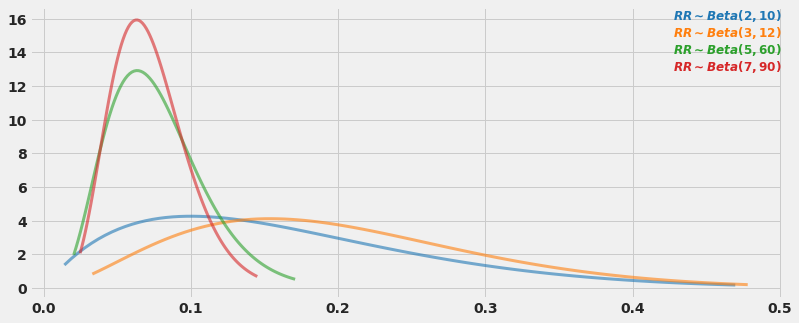

In [44]:
beta_plots([2, 3, 5, 7], [10, 12, 60, 90])

***

## 5. Multi Arm Bandits

<div style="text-align: right"
     
[top](#Experimentation-guide-in-Python)

In the AB testing framework, you can think that there is a period of `exporation` (the period when the test is running) and after that the `exploitation` period (we continue using the winner from then on). <br>

With A/B testing, you have a limited period of pure `exploration` where you allocate traffic in equal numbers to Version A and Version B. Once you declare a winner, you move into a long period of `exploitation`, where 100% of users go to the winning variation. 

One issue with this approach is that you waste resources on the losing variation while trying to gather data and learn which is the winner.

With `multi-armed bandit testing`, the tests are adaptive, and include periods of exploration and exploitation at the same time. They move traffic gradually towards winning variations, instead of forcing you to wait to declare a winner at the end of an experiment. This process is faster and more efficient because less time is spent on sending traffic to obviously inferior variations.

As a rule of thump, we prefer to run mutli-armed bandits in the following cases:
- When the test period is really short (we need the answer as soon as possible, i.e. its very expensive for us to keep on running the test)
- When the test period is really long (because for example, user preferences change over time).
- When Targeting is an issue (If certain types of users are more common than others, the multi-armed bandit can apply learned targeting rules sooner for more common users, while continuing to experiment on less common users)

Multi-Armed Bandits tries to minimize regret (If we knew which version is the best to begin with, we would have used that version. Then we would have gotten the best posible result. But because we dont know we need to to explore, so we are selecting suboptimal varsions to learn). We want to minimize the suboptimal selections.

The most known MAB (Multi-Armed Bandit) algorithms are:
- [Greedy](https://towardsdatascience.com/bandit-algorithms-34fd7890cb18)
- [Epsilon-Greedy](https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/)
- [UBC](https://towardsdatascience.com/the-upper-confidence-bound-ucb-bandit-algorithm-c05c2bf4c13f)
- [Thomson Sampling](https://towardsdatascience.com/thompson-sampling-fc28817eacb8)

Library [Contextual Babdits](https://contextual-bandits.readthedocs.io/en/latest/)

## 6. Calculating sample size for means

<div style="text-align: right"
     
[top](#Experimentation-guide-in-Python)

The formula for calulating the sample size when comparing means is the following:<br>
$n = \frac{k*(Var_1 + Var_2)}{(μ_1 - μ_2)^2}$<br>
Where $k = (Z_\frac{α}{2} - Z_β)^2$, usually $α=0.05$ and $β=0.2$, the denominator is the effect size we would like to detect<br>
When the experiment groups comes from the same underlying population, i.e. groups 1 and 2 have the same variance, the formula can be written as <br>
$n = \frac{k*2*Var}{(μ_1 - μ_2)^2}$, where $Var$ is the population variance<br>

In [45]:
import scipy.stats as stats
import numpy as np

In [46]:
def sample_size(diff_to_detect, variance, alpha=0.05, power=0.8):
    k = (stats.norm.ppf(1-alpha/2) - stats.norm.ppf(1-power))**2
    return int(np.ceil(k*2*variance/(diff_to_detect**2)))

In [47]:
sample_size(4, 2000)

1963

## 7. Assesing randomness

When we split users into treatment and control group we would also like them to be as comparable as possible, in order to attribute any difference between the two groups to the treatment effect alone

In [49]:
from dgp import dgp_rnd_assignment
from utils import *

In [50]:
df = dgp_rnd_assignment().generate_data()
df.head()

,Group,Arm,Gender,Age,Income
0,control,NaN,0,29.0,568.44
1,control,NaN,1,32.0,596.45
2,treatment,arm 3,0,29.0,380.86
3,control,NaN,0,25.0,476.38
4,treatment,arm 4,1,32.0,628.28


We have information on 1000 individuals, for which we observe gender, age and weekly income. Each individual is assigned either to the treatment or control group and treated individuals are distributed across four treatment arms.

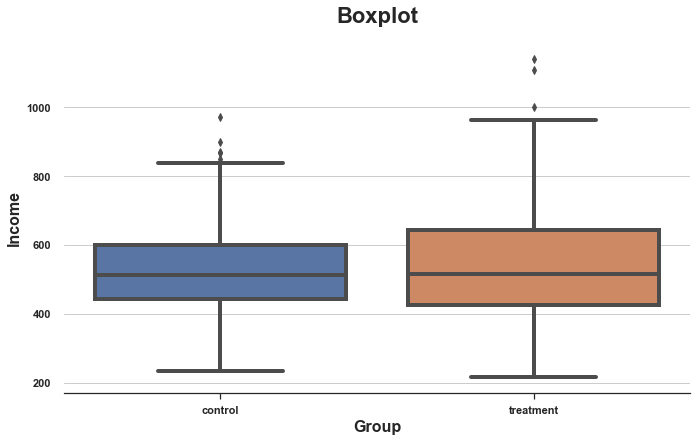

In [52]:
sns.boxplot(data=df, x='Group', y='Income');
plt.title("Boxplot");

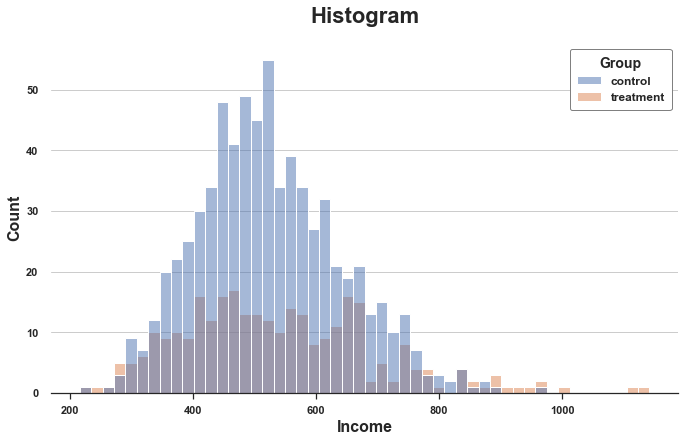

In [53]:
sns.histplot(data=df, x='Income', hue='Group', bins=50);
plt.title("Histogram");

There are multiple issues with this plot:

- Since the two groups have a different number of observations, the two histograms are not comparable
- The number of bins is arbitrary

We can solve this:

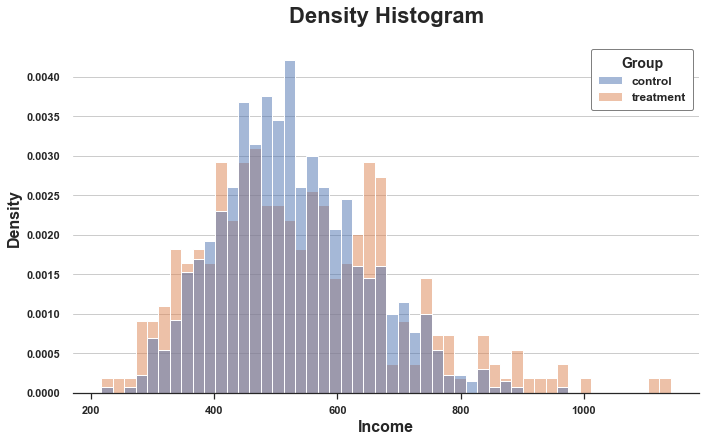

In [54]:
sns.histplot(data=df, x='Income', hue='Group', bins=50, stat='density', common_norm=False);
plt.title("Density Histogram");

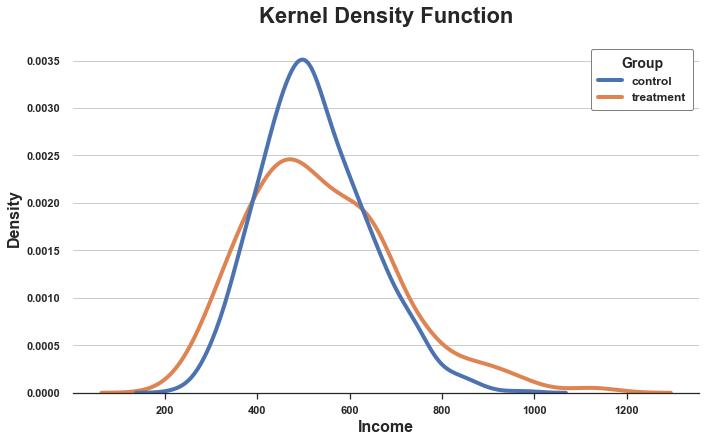

In [55]:
sns.kdeplot(x='Income', data=df, hue='Group', common_norm=False);
plt.title("Kernel Density Function");

A more transparent representation of the two distributions is their cumulative distribution function

- we do not need to make any arbitrary choice (e.g. number of bins)
- we do not need to perform any approximation (e.g. with KDE), but we represent all data points

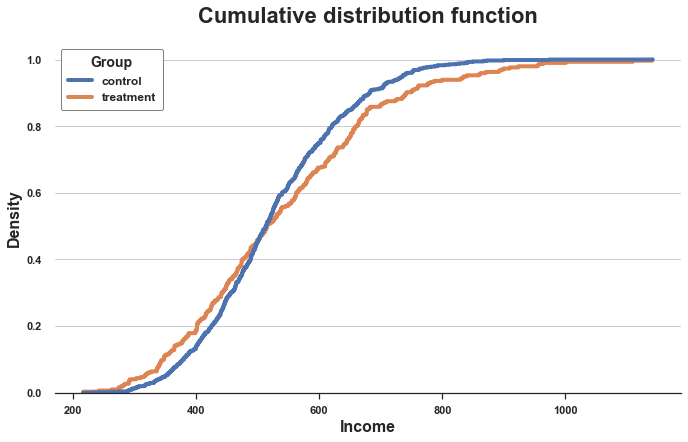

In [56]:
sns.histplot(x='Income', data=df, hue='Group', bins=len(df), stat="density",
             element="step", fill=False, cumulative=True, common_norm=False);
plt.title("Cumulative distribution function");

How should we interpret the graph?

- Since the two lines cross more or less at 0.5 (y axis), it means that their median is similar
- Since the orange line is above the blue line on the left and below the blue line on the right, it means that the distribution of the treatment group as fatter tails

How about a Q-Q plot

In [57]:
income = df['Income'].values
income_t = df.loc[df.Group=='treatment', 'Income'].values
income_c = df.loc[df.Group=='control', 'Income'].values

df_pct = pd.DataFrame()
df_pct['q_treatment'] = np.percentile(income_t, range(100))
df_pct['q_control'] = np.percentile(income_c, range(100))

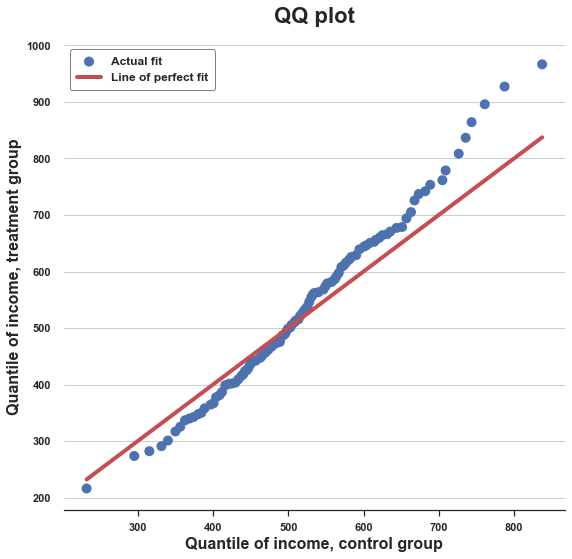

In [58]:
plt.figure(figsize=(8, 8))
plt.scatter(x='q_control', y='q_treatment', data=df_pct, label='Actual fit');
sns.lineplot(x='q_control', y='q_control', data=df_pct, color='r', label='Line of perfect fit');
plt.xlabel('Quantile of income, control group')
plt.ylabel('Quantile of income, treatment group')
plt.legend()
plt.title("QQ plot");

Lets use math to look at the differences

T-test
The first and most common test is the student t-test. T-tests are generally used to compare means. In this case, we want to test whether the means of the income distribution are the same across the two groups. The test statistic for the two-means comparison test is given by:

![Stat](https://miro.medium.com/max/720/1*tCnvcGUm9QWlKxoQ8miTUw.webp)

In [61]:
from scipy.stats import ttest_ind

stat, p_value = ttest_ind(income_c, income_t)
print(f"t-test: statistic={stat:.4f}, p-value={p_value:.4f}")
# t-test: statistic=-1.5549, p-value=0.1203

t-test: statistic=-1.5549, p-value=0.1203


The p-value of the test is 0.12, therefore we do not reject the null hypothesis of no difference in means across treatment and control groups.

Note: the t-test assumes that the variance in the two samples is the same so that its estimate is computed on the joint sample. Welch’s t-test allows for unequal variances in the two samples.

Standardized Mean Difference (SMD)

![SMD](https://miro.medium.com/max/720/1*XuXDj7ZllFHP5rK0_m2WJg.webp)

Usually, a value below 0.1 is considered a “small” difference.

In [67]:
from causalml.match import create_table_one

df['treatment'] = df['Group']=='treatment'
create_table_one(df, 'treatment', ['Gender', 'Age', 'Income'])

![](https://miro.medium.com/proxy/1*1PSHitUXsQ8r_FlHMRgbbQ.webp)

In the first two columns, we can see the average of the different variables across the treatment and control groups, with standard errors in parenthesis. In the last column, the values of the SMD indicate a standardized difference of more than 0.1 for all variables, suggesting that the two groups are probably different.

Mann–Whitney U Test

An alternative test is the Mann–Whitney U test. 

The null hypothesis for this test is that the two groups have the same distribution, while the alternative hypothesis is that one group has larger (or smaller) values than the other.

In [68]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(income_t, income_c)
print(f" Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Mann–Whitney U Test: statistic=106371.5000, p-value=0.6012


Mann–Whitney U Test: statistic=106371.5000, p-value=0.6012
We get a p-value of 0.6 which implies that we do not reject the null hypothesis that the distribution of income is the same in the treatment and control groups.

Permutation Tests

A non-parametric alternative is permutation testing. The idea is that, under the null hypothesis, the two distributions should be the same, therefore shuffling the group labels should not significantly alter any statistic.

In [70]:
sample_stat = np.mean(income_t) - np.mean(income_c)
stats = np.zeros(1000)
for k in range(1000):
    labels = np.random.permutation((df['Group'] == 'treatment').values)
    stats[k] = np.mean(income[labels]) - np.mean(income[labels==False])
p_value = np.mean(stats > sample_stat)

print(f"Permutation test: p-value={p_value:.4f}")

Permutation test: p-value=0.0530


In [71]:
# Permutation test: p-value=0.0530

The permutation test gives us a p-value of 0.053, implying a weak non-rejection of the null hypothesis at the 5% level.

How do we interpret the p-value? It means that the difference in means in the data is larger than 1–0.0560 = 94.4% of the differences in means across the permuted samples.

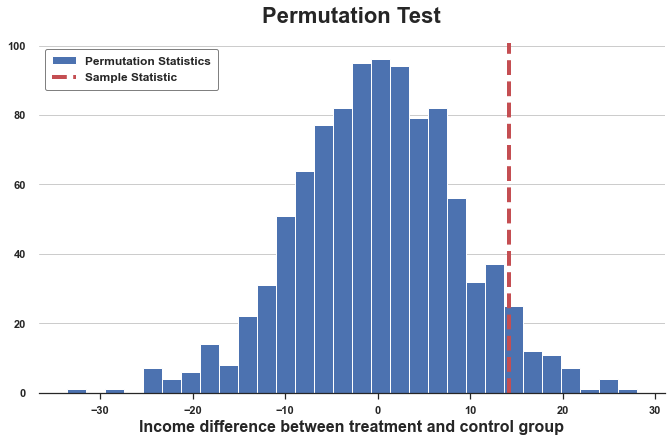

In [72]:
plt.hist(stats, label='Permutation Statistics', bins=30);
plt.axvline(x=sample_stat, c='r', ls='--', label='Sample Statistic');
plt.legend();
plt.xlabel('Income difference between treatment and control group')
plt.title('Permutation Test');

Chi-Squared Test
The chi-squared test is a very powerful test that is mostly used to test differences in frequencies.

One of the least known applications of the chi-squared test is testing the similarity between two distributions. The idea is to bin the observations of the two groups. If the two distributions were the same, we would expect the same frequency of observations in each bin. Importantly, we need enough observations in each bin, in order for the test to be valid.

In [73]:
# Init dataframe
df_bins = pd.DataFrame()

# Generate bins from control group
_, bins = pd.qcut(income_c, q=10, retbins=True)
df_bins['bin'] = pd.cut(income_c, bins=bins).value_counts().index

# Apply bins to both groups
df_bins['income_c_observed'] = pd.cut(income_c, bins=bins).value_counts().values
df_bins['income_t_observed'] = pd.cut(income_t, bins=bins).value_counts().values

# Compute expected frequency in the treatment group
df_bins['income_t_expected'] = df_bins['income_c_observed'] / np.sum(df_bins['income_c_observed']) * np.sum(df_bins['income_t_observed'])

df_bins

,bin,income_c_observed,income_t_observed,income_t_expected
0,"(232.26, 380.496]",70,46,29.075391
1,"(380.496, 425.324]",70,30,29.075391
2,"(425.324, 456.795]",70,24,29.075391
3,"(456.795, 488.83]",71,26,29.490754
4,"(488.83, 513.66]",70,18,29.075391
5,"(513.66, 540.048]",70,19,29.075391
6,"(540.048, 576.664]",71,21,29.490754
7,"(576.664, 621.022]",70,25,29.075391
8,"(621.022, 682.003]",70,42,29.075391
9,"(682.003, 973.46]",71,41,29.490754


![](https://miro.medium.com/max/720/1*BGf27e96gUi8dYQJoH9z2Q.webp)

In [76]:
from scipy.stats import chisquare

stat, p_value = chisquare(df_bins['income_t_observed'], df_bins['income_t_expected'])
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=32.1432, p-value=0.0002


In [77]:
# Chi-squared Test: statistic=32.1432, p-value=0.0002

Kolmogorov-Smirnov Test

The Kolmogorov-Smirnov test is probably the most popular non-parametric test to compare distributions. The idea of the Kolmogorov-Smirnov test is to compare the cumulative distributions of the two groups. In particular, the Kolmogorov-Smirnov test statistic is the maximum absolute difference between the two cumulative distributions.

![](https://miro.medium.com/max/720/1*p93GVnGv7D6K0JwO9cnQCg.webp)

In [78]:
df_ks = pd.DataFrame()
df_ks['Income'] = np.sort(df['Income'].unique())
df_ks['F_control'] = df_ks['Income'].apply(lambda x: np.mean(income_c<=x))
df_ks['F_treatment'] = df_ks['Income'].apply(lambda x: np.mean(income_t<=x))
df_ks.head()

,Income,F_control,F_treatment
0,216.36,0.000000,0.003378
1,232.26,0.001420,0.003378
2,243.15,0.001420,0.006757
3,259.88,0.002841,0.006757
4,262.82,0.002841,0.010135


In [79]:
k = np.argmax( np.abs(df_ks['F_control'] - df_ks['F_treatment']))
ks_stat = np.abs(df_ks['F_treatment'][k] - df_ks['F_control'][k])

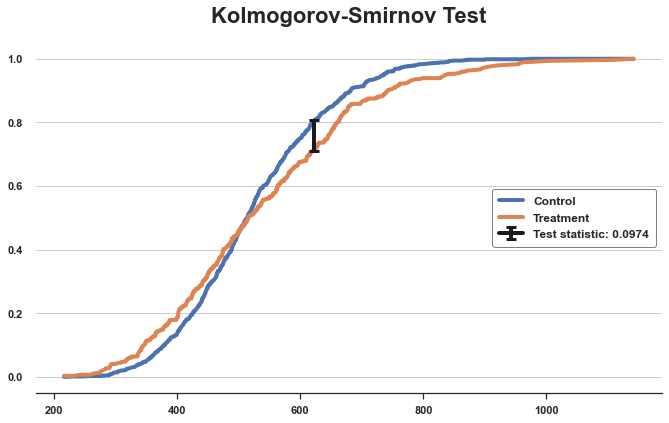

In [80]:
y = (df_ks['F_treatment'][k] + df_ks['F_control'][k])/2
plt.plot('Income', 'F_control', data=df_ks, label='Control')
plt.plot('Income', 'F_treatment', data=df_ks, label='Treatment')
plt.errorbar(x=df_ks['Income'][k], y=y, yerr=ks_stat/2, color='k',
             capsize=5, mew=3, label=f"Test statistic: {ks_stat:.4f}")
plt.legend(loc='center right');
plt.title("Kolmogorov-Smirnov Test");

From the plot, we can see that the value of the test statistic corresponds to the distance between the two cumulative distributions at income~650. For that value of income, we have the largest imbalance between the two groups.

We can now perform the actual test using the kstest function from scipy.



In [81]:
from scipy.stats import kstest

stat, p_value = kstest(income_t, income_c)
print(f" Kolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Kolmogorov-Smirnov Test: statistic=0.0974, p-value=0.0355


The p-value is below 5%: we reject the null hypothesis that the two distributions are the same, with 95% confidence.

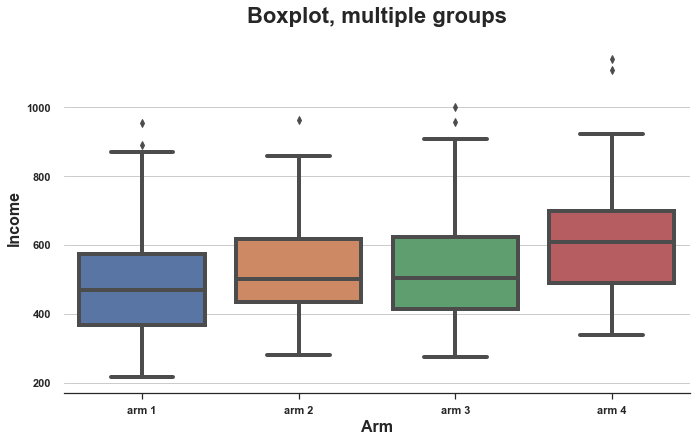

In [82]:
sns.boxplot(x='Arm', y='Income', data=df.sort_values('Arm'));
plt.title("Boxplot, multiple groups");

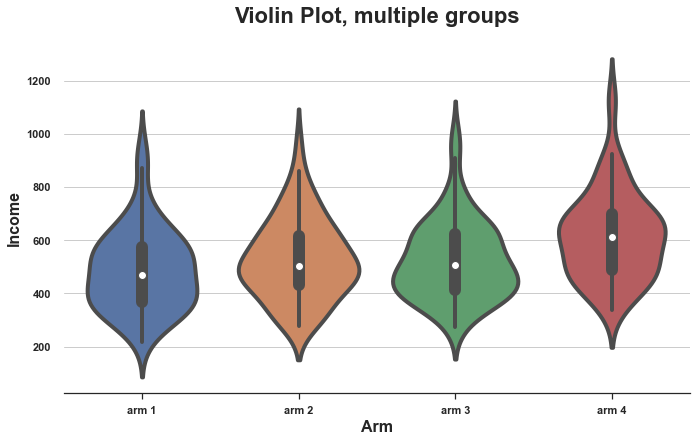

In [83]:
sns.violinplot(x='Arm', y='Income', data=df.sort_values('Arm'));
plt.title("Violin Plot, multiple groups");

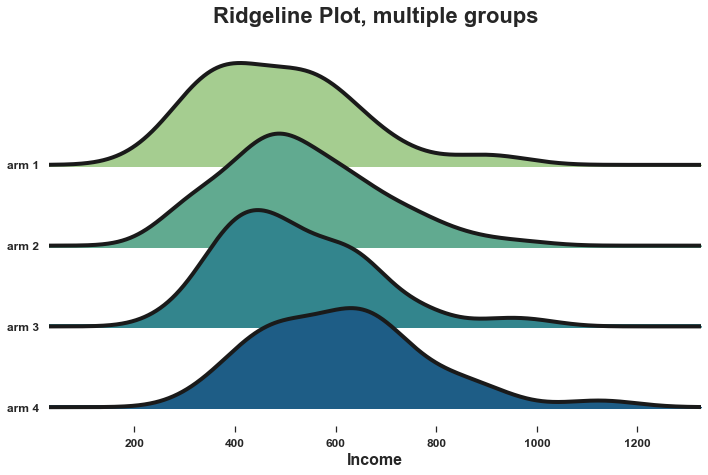

In [86]:
from joypy import joyplot

joyplot(df, by='Arm', column='Income', colormap=sns.color_palette("crest", as_cmap=True));
plt.xlabel('Income');
plt.title("Ridgeline Plot, multiple groups");